## Demonstration of the proposed confidence interval (CI) and its coverage guarantee

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gen_data
import util
import ci

In [2]:
# Proposed method

def run_proposed_method():
    n = 5
    m = 5
    d = 1
    delta_mu = 5
    dim_t = n * m

    X_obs, Y_obs, true_X, true_Y = gen_data.generate(n, m, d, delta_mu)

    X_obs_vec = X_obs.flatten().copy().reshape((n * d, 1))
    Y_obs_vec = Y_obs.flatten().copy().reshape((m * d, 1))

    true_X_vec = true_X.flatten().copy().reshape((n * d, 1))
    true_Y_vec = true_Y.flatten().copy().reshape((m * d, 1))

    data_obs = np.vstack((X_obs_vec, Y_obs_vec)).copy()

    # Cost matrix
    C = np.zeros((n, m))

    for i in range(n):
        e_x = X_obs[i, :]
        for j in range(m):
            e_y = Y_obs[j, :]
            C[i, j] = np.sum(np.abs(e_x - e_y))

    c_vec = C.copy().flatten().reshape((dim_t, 1))

    Theta, list_sign, list_kronecker_product = util.construct_Theta(n, m, d, data_obs)

    # LP
    S, u, G, h = util.construct_S_u_G_h(n, m)
    lp_res = util.LP_solver(c_vec, S, u, G, h)

    # OT plan vector
    t_hat = np.around(lp_res.x, 10)

    # Active set and non-active set
    A = lp_res.basis.copy().tolist()
    Ac = []
    for i in range(dim_t):
        if i not in A:
            Ac.append(i)

    t_hat_A = t_hat[A]

    # Construct eta
    Theta_A_ast = Theta[A, :].copy()
    eta = np.dot(Theta_A_ast.T, np.reshape(t_hat_A, (len(A), 1)))

    # etaTdata
    etaTdata = np.dot(eta.T, data_obs)[0][0]

    # Construct a_line and b_line
    a, b = util.compute_a_b(data_obs, eta, n * d + m * d)

    # ========= Find truncation region (interval) =========
    q0 = np.dot(Theta, a)
    q1 = np.dot(Theta, b)

    q0_A = q0[A, :].copy()
    q0_Ac = q0[Ac, :].copy()

    q1_A = q1[A, :].copy()
    q1_Ac = q1[Ac, :].copy()

    S_ast_A = S[:, A].copy()
    S_ast_A_inv = np.linalg.inv(S_ast_A)
    S_ast_Ac = S[:, Ac].copy()

    v0 = q0_Ac.T - np.dot(q0_A.T, np.dot(S_ast_A_inv, S_ast_Ac))
    v1 = q1_Ac.T - np.dot(q1_A.T, np.dot(S_ast_A_inv, S_ast_Ac))

    v0 = np.around(v0.flatten(), 10)
    v1 = np.around(v1.flatten(), 10)

    Vminus = np.NINF
    Vplus = np.Inf

    # Selection event for A
    for i in range(len(v0)):
        a_coef = - v1[i]
        b_coef = v0[i]

        if a_coef == 0.0:
            continue

        temp = b_coef / a_coef

        if a_coef > 0:
            Vplus = min(Vplus, temp)
        elif a_coef < 0:
            Vminus = max(Vminus, temp)

    # Selection even for absolute in cost
    for k in range(d):
        element_wise_product = list_sign[k] * list_kronecker_product[k]

        vector_left = - np.dot(element_wise_product, b).copy().flatten()
        vector_right = np.dot(element_wise_product, a).flatten()

        for i in range(len(vector_left)):
            a_coef = vector_left[i]
            b_coef = vector_right[i]

            if -1e-8 <= a_coef <= 1e-8:
                if b_coef > 0:
                    continue

            temp = b_coef / a_coef

            if a_coef > 0:
                Vplus = min(Vplus, temp)
            elif a_coef < 0:
                Vminus = max(Vminus, temp)

    true_data = np.vstack((true_X_vec, true_Y_vec)).copy()
    tn_mu = np.dot(eta.T, true_data)[0][0]
    cov = np.identity(n * d + m * d)

    CI = ci.compute_ci_with_constructed_interval([[Vminus, Vplus]], eta, etaTdata, cov, 0.05)

    return tn_mu, CI

Iteration: 0
Iteration: 2
Iteration: 4
Iteration: 6
Iteration: 8
Iteration: 10
Iteration: 12
Iteration: 14
Iteration: 16
Iteration: 18
Iteration: 20
Iteration: 22
Iteration: 24
Iteration: 26
Iteration: 28
Iteration: 30
Iteration: 32
Iteration: 34
Iteration: 36
Iteration: 38
Iteration: 40
Iteration: 42
Iteration: 44
Iteration: 46
Iteration: 48
Iteration: 50
Iteration: 52
Iteration: 54
Iteration: 56
Iteration: 58

Coverage 0.95


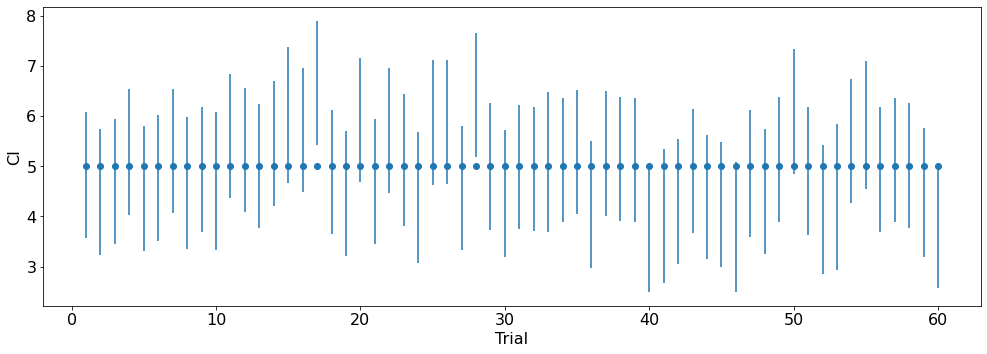

In [3]:
if __name__ == '__main__':
    np.random.seed(2)

    list_true = []
    list_lb = []
    list_ub = []

    max_iteration = 60
    detect = 0
    count = 0

    list_length = []

    for each_iter in range(max_iteration):
        if each_iter % 2 == 0:
            print('Iteration:', each_iter)

        tn_mu, CI = run_proposed_method()

        detect = detect + 1

        list_length.append(CI[1] - CI[0])

        if CI[0] <= tn_mu <= CI[1]:
            count = count + 1

        list_true.append(tn_mu)
        list_lb.append(CI[0])
        list_ub.append((CI[1]))

    print()
    print('==========')
    print('Coverage', count / detect)
    print('==========')

    util.plot(list_true, list_lb, list_ub)

Given the significance level alpha = 0.05, the coverage guaratee is 0.95 which demonstrates the validity of the proposed selective CI. In other words, when we repeat the experiments 60 times, there are 57 times where the proposed CI contains the true distance.